# Improving Your Multi-Factor Model with the California Housing Price Dataset

#### How do you improve your goodness of fit on your multi-factor model?  Below is a demonstration using the Support Vector Regression (SVR), a contemporary model, with the California Housing dataset, which is an improvement on the classical model of Multiple Linear Regression (MLR).  Data points that are outliers and subsets of data that are linearly inseparable are some of the advantages of SVR can handle over MLR.  

#### We first load the native dataset from the sklearn libaries followed by exploratory data analysis.  Split, train, test with all the features and score the goodness of fit.  Thereafter, there is a feature assessment using Variance Inflation Factor (VIF) to remove any redundant features and we repeat the process to improve our score.


In [15]:
# Required imports
import numpy as np
import pandas as pd

# Data Visualization libary
import matplotlib.pyplot as plt
import seaborn as sns

# Required data science libaries
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Remove annoying warnings
import warnings
warnings.filterwarnings("ignore")

#### Importing the Dataset

In [71]:
from sklearn.datasets.california_housing import fetch_california_housing
cal_housing = fetch_california_housing()

## Exploratory Data Analysis

#### Assign the target variable of the price of housing as y and the feature dataset  as X.

In [3]:
X, y = cal_housing.data, cal_housing.target

names = cal_housing.feature_names

#### A description of the California housing dataset can be found here below.

http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

In [4]:
cal_housing.data.shape

(20640, 8)

#### There are 20,640 observations with 8 features.

In [5]:
print(cal_housing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


#### Assign the variables for analysis

In [72]:
df = pd.DataFrame(data=X)

MedInc, HouseAge, AveRooms, AveBedrms = df.loc[:, 0], df.loc[:, 1], df.loc[:, 2], df.loc[:, 3]

Population, AveOccup, Latitude, Longitude = df.loc[:, 4], df.loc[:, 5], df.loc[:, 6], df.loc[:, 7]

#### If we look at the descriptive statistics, then there is good variability across all the features.  

In [87]:
pd.options.display.float_format = '{:,.2f}'.format # Limit output to fewer decimal places
df.describe()

,0,1,2,3,4,5,6,7,Price
count,"20,640.00","20,640.00","20,640.00","20,640.00","20,640.00","20,640.00","20,640.00","20,640.00","20,640.00"
mean,3.87,28.64,5.43,1.10,"1,425.48",3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,"1,132.46",10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,"1,166.00",2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,"1,725.00",3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,"35,682.00","1,243.33",41.95,-114.31,5.00


#### Let's see how related the features are to each other . . . 

Text(0.5, 1, 'Correlation Matrix Heatmap of Independent Features')

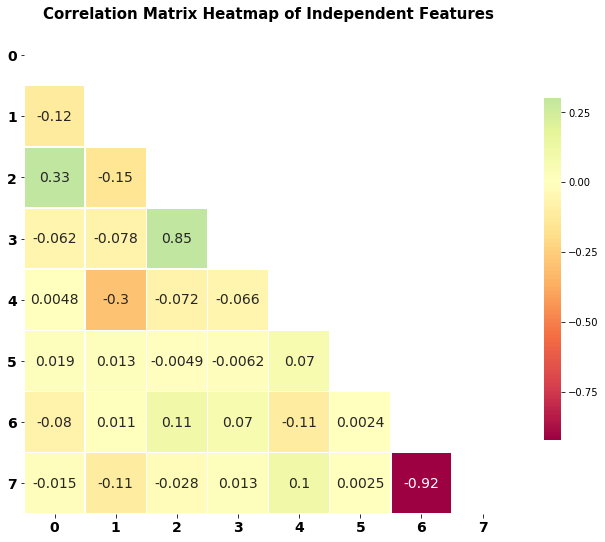

In [8]:
# Generate a correlation matrix function and assign it
corr = df.corr()

# To remove redundant output, generate an upper triangle mask 
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask, correct aspect ratio and Spectral color theme
sns.heatmap(corr, mask=mask, cmap='Spectral', vmax=.3, center=0, annot_kws={"size": 14}, 
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .7})

# Make it readable and nice
plt.yticks(rotation=0, fontweight='bold', fontsize=14)
plt.xticks(fontweight='bold', fontsize=14)
plt.title('Correlation Matrix Heatmap of Independent Features'
          , fontweight='bold', fontsize=15,color='k')

#### The second to last to variable, labelled 6 or Latitude, is inversely related to 7 of Longitude, and there is tandem movement of 2 and 3, AveRooms and AveBedrms.  Common knowledge can accept Latitude and Longitude are opposites and the number of rooms and bedrooms are related in some fashion.  The rest of the features do not have an association as the correlation values are near zero.

#### We will see further below, how this will play a role in improving our model score.

In [74]:
# create target variable to set up for multi-factor modeling
df['Price'] = cal_housing.target
df.head(3)

,0,1,2,3,4,5,6,7,Price
0,8.33,41.00,6.98,1.02,322.00,2.56,37.88,-122.23,4.53
1,8.30,21.00,6.24,0.97,"2,401.00",2.11,37.86,-122.22,3.58
2,7.26,52.00,8.29,1.07,496.00,2.80,37.85,-122.24,3.52


## Short Explanation of Support Vector Regression Model

One of many, multi-factor models, is the Support Vector Machine (SVM) framework.  Briefly, a single dataset with different attributes is split into two subsets by an optimal line with the only the widest margins drawn to separate both sides of data.  Specifically, the drawn line has the furthest distance between the two subsets of data and the margins are decision boundaries.  The support vectors are data points on the margins that treat the rest of the data points off margin by optimizing and honoring constraints.  No data points are removed or data values changed as the properties of distance and magnitude are favorable in a non - parametric approach, including space transformation.

Mathematically, this is called a linear separable dataset as the split line is a hyperplane followed by LaGrangian multipliers that optimize the datasets and dependent on the linear sum of the sample set.  Also, if not linear separable, then there is a transformation of space from 2 dimensional feature space to 3 dimensional feature space.  The original paper that started this, is below.

http://image.diku.dk/imagecanon/material/cortes_vapnik95.pdf

An extension of SVM is the support vector regression (SVR).


## Split train-test dataset

#### Split the dataset into two for training and testing with a target value, y, and a set of predictor values, X. 

#### Y = California Housing Price

#### X = All other features

In [75]:
X = df.drop('Price', axis = 1)

In [76]:
Y = df['Price']

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 5)

print(X_train.shape)

print(X_test.shape)

print(Y_train.shape)

print(Y_test.shape)

(13828, 8)
(6812, 8)
(13828,)
(6812,)


#### Implement by fitting and scoring the SVR model with our dataset

In [78]:
clf = svm.SVR()

In [79]:
clf.fit(X, y) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [80]:
clf.score(X,y)

0.7506287852385003

#### Just like MLR, in SVR, we have a goodness of fit measure, the score.  A 0.75 is good as 1.00 would indicate overfitting or the unnessary capture of data noise that would effect our prediction.  Another way to understand the score, is the percentage of the variance in the target variable that is explained by the set of 8 features, collectively . . . or how much do the features explain the target price of housing in California.

### Improving the Support Vector Regression with a Check on Multicollinearity

#### One way of feature evalution is to score each of them, in terms of their correlation to other features. Multicollinearity or Collinearity occurs when two features trying to explain the target variable contain redundant information about the variance of a give dataset so we can remove them from the feature dataset. 

#### Variance Inflation Factor is one method to check Multicollinearity and it is the complements reciprocal of the score or 1 / (1 - R squared).

In [81]:
#  Compute VIF for each feature 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,11.50,0
1,7.20,1
2,46.00,2
3,43.60,3
4,2.90,4
5,1.10,5
6,559.90,6
7,633.70,7


#### Consistent with our Correlation Matrix Heatmap in Exploratory Data Analysis, we have 1, 4 and 5, HouseAge, Population and AveOccup are not correlated as they are less than 10.  Greater than 10 we have  AveRooms and AveBedrms, 2 and 3, respectively, with some correlation, but there is multicollinearity in the last two features.  

#### Let's drop 6 and 7, Latitude and Longitude, as they are paired features and re-run SVR.

In [82]:
df2 = df.drop([6,7], axis=1)

#### Reassign the X variable as X2

In [83]:
X2 = df2

#### No need to change the target variable y, Calfornia Median Housing Price

#### Implement again by fitting and scoring the SVR model with new dataset X2


In [84]:
clf = svm.SVR()

In [85]:
clf.fit(X2, y) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
clf.score(X2,y)

0.8304411489549803

#### We have an improvement of the goodness of fit by about 8 points. 